In [1]:
%matplotlib inline
import matplotlib
from matplotlib import style 
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import datetime as dt

In [2]:
import sqlalchemy 
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func



In [3]:
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [4]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [5]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [6]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [7]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [8]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
latest_data = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
latest_data = latest_data [0]
latest_data

'2017-08-23'

In [9]:
# Calculate the date 1 year ago from the last data point in the database
first_date = dt.datetime.strptime(latest_data,"%Y-%m-%d") - dt.timedelta(days=366)
# Perform a query to retrieve the data and precipitation scores
lastyear = session.query(Measurement.date, Measurement.prcp).\
                        filter(Measurement.date >= first_date).\
                        order_by(Measurement.date).all()
lastyear

[('2016-08-23', 0.0),
 ('2016-08-23', 0.15),
 ('2016-08-23', 0.05),
 ('2016-08-23', None),
 ('2016-08-23', 0.02),
 ('2016-08-23', 1.79),
 ('2016-08-23', 0.7),
 ('2016-08-24', 0.08),
 ('2016-08-24', 2.15),
 ('2016-08-24', 2.28),
 ('2016-08-24', None),
 ('2016-08-24', 1.22),
 ('2016-08-24', 2.15),
 ('2016-08-24', 1.45),
 ('2016-08-25', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-25', 0.0),
 ('2016-08-25', 0.0),
 ('2016-08-25', 0.21),
 ('2016-08-25', 0.06),
 ('2016-08-25', 0.11),
 ('2016-08-26', 0.0),
 ('2016-08-26', 0.03),
 ('2016-08-26', 0.02),
 ('2016-08-26', 0.04),
 ('2016-08-26', 0.0),
 ('2016-08-26', 0.01),
 ('2016-08-27', 0.0),
 ('2016-08-27', 0.18),
 ('2016-08-27', 0.02),
 ('2016-08-27', 0.0),
 ('2016-08-27', 0.12),
 ('2016-08-27', None),
 ('2016-08-28', 0.01),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.6),
 ('2016-08-28', 2.07),
 ('2016-08-29', 0.0),
 ('2016-08-29', 0.17),
 ('2016-08-29', 0.04),
 ('2016-08-29', None),
 ('2016-08-29', 0.0),

In [10]:
# Save the query results as a Pandas DataFrame and set the index to the date column
lastyear_df = pd.DataFrame(lastyear, columns=['Date', 'Precipitation'])
lastyear_df.set_index('Date', inplace = True)


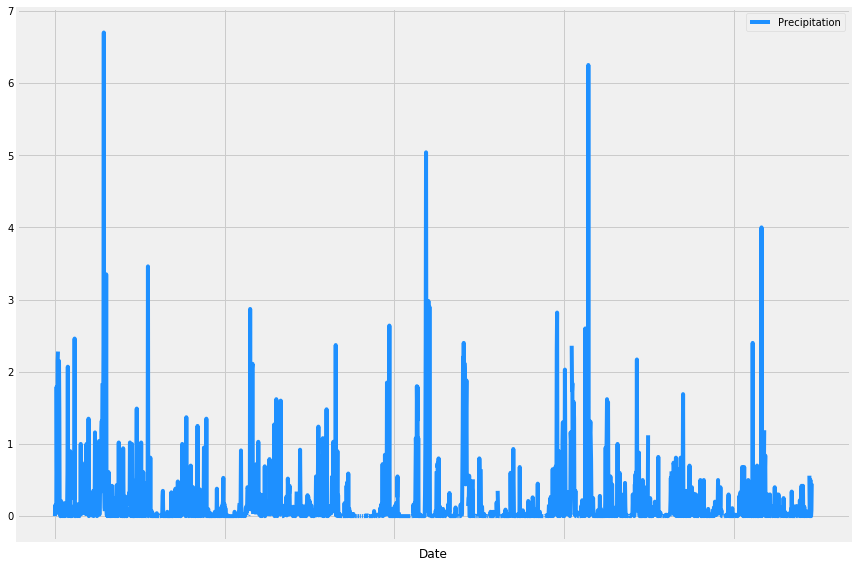

In [11]:
lastyear_df.plot(figsize = (12,8), x_compat = True, color = 'dodgerblue')
plt.tight_layout()
plt.show()

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
lastyear_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [13]:
# Design a query to show how many stations are available in this dataset?
num_station = session.query(func.count(Station.station)).scalar()
num_station

9

In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
active_station = session.\
    query(Measurement.station, func.count(Measurement.station)).\
    group_by (Measurement.station).\
    order_by (func.count(Measurement.station).\
    desc()).all()

active_station


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
#df_active = pd.DataFrame(active_station, columns = ['Station', 'Number of actives'])


In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
temperatures = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
temperatures


[(54.0, 85.0, 71.66378066378067)]

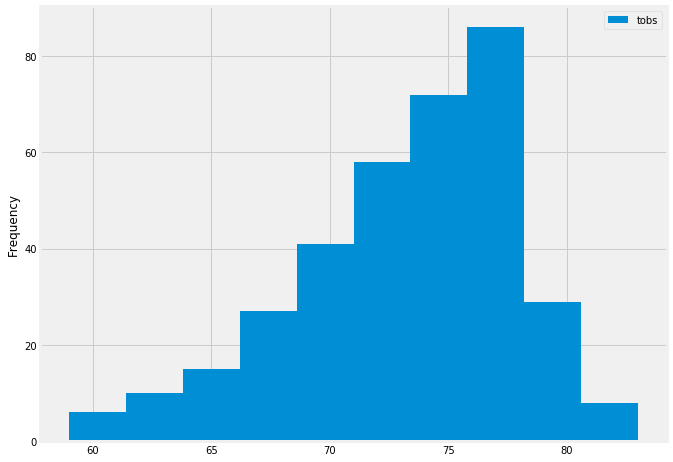

In [17]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station 
#and plot the results as a histogram
list_temp = session.query(Measurement.tobs).filter(Measurement.date > first_date).filter(Measurement.station == 'USC00519281').all()
df_temp = pd.DataFrame(list_temp,columns = ['tobs'])
df_temp.plot(kind='hist',linewidth = .5, figsize = (10,8))
plt.show()




In [18]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    temp = session.query(func.min(Measurement.tobs),func.avg(Measurement.tobs),func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).\
        filter(Measurement.date <= end_date).all()
    TMIN, TAVE, TMAX = temp[0]
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
        
# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [19]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    data_start = start_date - dt.timedelta(days=366)
    data_end = end_date- dt.timedelta(days=366)
    
    temp = session.query(func.min(Measurement.tobs),func.avg(Measurement.tobs),func.max(Measurement.tobs)).\
        filter(Measurement.date >= data_start).\
        filter(Measurement.date <= data_end).all()
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= data_start).filter(Measurement.date <= data_end).all()
        
    TMIN, TAVE, TMAX = temp[0]
my_trip = calc_temps(dt.datetime(2018,1,1),dt.datetime(2018,1,7))
print(my_trip)   


[(62.0, 68.05714285714286, 74.0)]


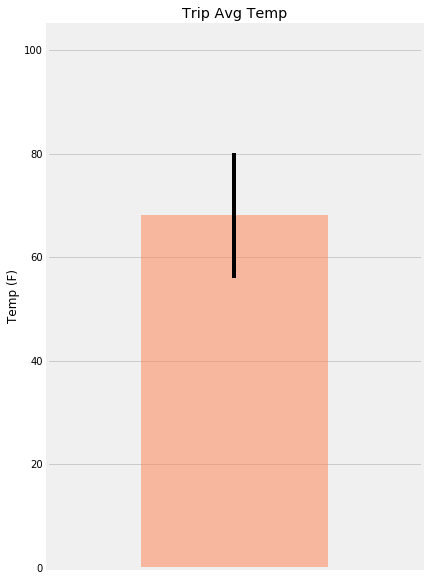

In [20]:
# Plot the results from your previous query as a bar chart. 
my_trip_df = pd.DataFrame(my_trip, columns = ['TMIN','TAVE','TMAX'])
# Use "Trip Avg Temp" as your Title

# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

my_trip_df.plot.bar(y = 'TAVE', yerr = (my_trip_df['TMAX']- my_trip_df['TMIN']), title = "Trip Avg Temp", color = 'coral', alpha = 0.5, figsize = (6,10))
plt.ylabel("Temp (F)")
plt.xticks(np.arange(1, 1.0))
plt.ylim([0,105])
plt.gca().legend_.remove()
plt.show()



In [21]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
a = session.query(Measurement.station, Station.name, Station.latitude,Station.longitude, Station.elevation, func.avg(Measurement.prcp))\
                  .filter(Measurement.station == Station.station)\
                  .filter(Measurement.date >= '2017-01-01')\
                  .filter(Measurement.date <= '2017-01-07')\
                  .group_by(Measurement.station)\
                  .order_by(func.avg(Measurement.prcp).desc())\
                  .all()
print(a)


[('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.1525), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.08571428571428572), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.08571428571428572), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.049999999999999996), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.028571428571428574), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0)]


In [22]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [23]:
def daily_normals(start_date,end_date):
   
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    daily_temps = session.query(*sel)\
    .filter(func.strftime("%m-%d",Measurement.date) >= start_date)\
    .filter(func.strftime("%m-%d",Measurement.date) <= end_date)\
    .group_by(func.strftime("%m-%d", Measurement.date)).all()

    return daily_temps
                                
b = daily_normals("01-01","01-07")
b


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [24]:
travel_date = ['2018-01-01','2018-01-02','2018-01-03','2018-01-04','2018-01-05','2018-01-06','2018-01-07']

In [25]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_dates = pd.DataFrame(b,columns=["tmin","tavg","tmax"])
trip_dates['date']= travel_date
trip_dates['date']= pd.to_datetime(trip_dates['date'], format='%Y-%m-%d')
trip_dates.set_index('date',inplace=True)

trip_dates.head()


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


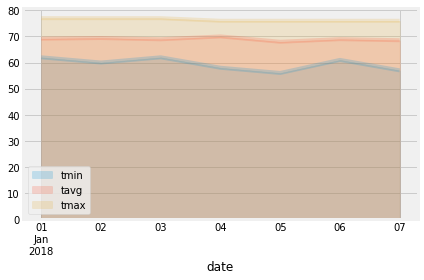

In [26]:
# Plot the daily normals as an area plot with `stacked=False`
trip_dates.plot.area(alpha=.2, stacked=False)
plt.tight_layout()
plt.xticks()
plt.show()